In [44]:
import os

from syntax_sugar import END, pipe
from syntax_sugar import process_syntax as p
from syntax_sugar import thread_syntax as t
NTHR = 16
import os
from os.path import join

In [45]:
import h5py

In [46]:
from scipy.integrate import quad

import TMQGP as tm
from numpy import *

import QuarkTM
from QuarkTM import Channel, ChannelGroup, ChannelL, Particle

import matplotlib
matplotlib.style.use('publication23')

mQ = 0.6

qrange = linspace(0, 5, 51)
erange = linspace(-5, 5, 201)
eps = 10e-2
# pt = QuarkTM.Particle(mQ, qrange, erange, eps=5e-2)

G = 5
L = 0.5
screen = 0.05
G1 = 4

# ch = QuarkTM.Channel(pt, pt, T, G=8, screen=0, ds=4, da=1, Fa=1)

import tqdm

from scipy.optimize import minimize

params = {'G' : G, 'L' : L, 'screen' : screen}
params_rep = {'G' : -G, 'L' : L, 'screen' : screen}
params1 = {'G' : G1, 'L' : L, 'screen' : screen}
params_rep1 = {'G' : -G1, 'L' : L, 'screen' : screen}


pss = [params, params1]
pss_rep = [params_rep, params_rep1]
mu = 0
lmax = 1

In [47]:
T = 0.25

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
def f(x, T):
    return 1/(exp(x/T) + 1)

Start of iterations

In [103]:
subtr = 1

In [134]:
mu_frac = 0.5

In [135]:
folder = 'test_8ch_trange_mu=%.2f_2'%(mu_frac)
if subtr:
    folder += '_subtr'

if not os.path.exists(folder):
    os.mkdir(folder)

In [136]:
quark_run = Particle(mQ, qrange, erange, eps=eps, mu=mu)
aquark_run = Particle(mQ, qrange, erange, eps=eps, mu=mu)

In [137]:
imss = array([array([-eps for q in qrange])]*2).transpose()
ress = array([array([0. for q in qrange])]*2).transpose()

In [138]:
eArr = array([erange for q in qrange]).transpose()

In [139]:
omKs = array([sqrt(mQ**2 + qrange**2)]*2).transpose()

In [140]:
DELTA = 1

In [141]:
Trange = linspace(0.15, 0.55, 21)

In [142]:
Trange

array([0.15, 0.17, 0.19, 0.21, 0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35,
       0.37, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55])

In [132]:
for T in Trange:
    mu = mu_frac * T
    DELTA = 1
    print('Processing T = ', T)
    while DELTA > 1e-3:
        
        # if len(ims) == 0 or len(res) == 0:
        channels_QQ = QuarkTM.ChannelGroup(mu0=False)
        channels_QA = QuarkTM.ChannelGroup(mu0=False)
        channels_AA = QuarkTM.ChannelGroup(mu0=False)
        channels_AQ = QuarkTM.ChannelGroup(mu0=False)
        
        # ImS_K_Arr = array([ims for e in er|ange])
        # ReS_K_Arr = array([res for e in erange])
        
        ImS_K_Arrs = [array([ims for e in erange]) for ims in imss.transpose()]
        ReS_K_Arrs = [array([res for e in erange]) for res in ress.transpose()]
        
        
        omArrs = [array([omk for e in erange]) for omk in omKs.transpose()]
        
        G2_QQ = (1 - 2*f(omArrs[0], T)) / (eArr - 2*omArrs[0] - 1j*2*ImS_K_Arrs[0] + 2*mu)
        G2_QA = (1 - f(omArrs[0], T) - f(omArrs[1], T)) / (eArr - omArrs[0] - omArrs[1] - 1j*(ImS_K_Arrs[0] + ImS_K_Arrs[1]))
        G2_AA = (1 - 2*f(omArrs[1], T)) / (eArr - 2*omArrs[1] - 1j*2*ImS_K_Arrs[1] - 2*mu)
        
        
        channels_QQ.addChannel(
            QuarkTM.ChannelL('qq3', lmax, quark_run, quark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_QQ)
        )
    
        channels_QQ.addChannel(
            QuarkTM.ChannelL('qq6', lmax, quark_run, quark_run, T, pss_rep, ds=4, da=6, Fa=1/4, mu=mu, G2=G2_QQ)
        )
    
        channels_QA.addChannel(
            QuarkTM.ChannelL('qa8', lmax, quark_run, aquark_run, T, pss_rep, ds=4, da=8, Fa=1/8, mu=mu, G2=G2_QA)
        )
        
        channels_QA.addChannel(
            QuarkTM.ChannelL('qa1', lmax, quark_run, aquark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QA)
        )
        
        channels_AA.addChannel(
            QuarkTM.ChannelL('aa3', lmax, aquark_run, aquark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_AA)
        )
        
        channels_AQ.addChannel(
            QuarkTM.ChannelL('aq1', lmax, aquark_run, quark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QA)
        )
    
        channels_AA.addChannel(
            QuarkTM.ChannelL('aa6', lmax, aquark_run, aquark_run, T, pss_rep, ds=4, da=6, Fa=1/4, mu=mu, G2=G2_AA)
        )
    
        channels_AQ.addChannel(
            QuarkTM.ChannelL('aq8', lmax, aquark_run, quark_run, T, pss_rep, ds=4, da=8, Fa=1/8, mu=mu, G2=G2_QA)
        )
    
        chs_Q = [channels_QQ, channels_QA]
        chs_A = [channels_AQ, channels_AA]
        
        Gs_Q = [G2_QQ, G2_QA]
        Gs_A = [G2_QA, G2_AA]
    
        omKs_old = omKs.copy()
        
        omKs = []
        ress = []
        imss = []

        def get_xs(k):
            xs = []
            res = []
            ims = []
            for i, chs, Gs, lbl in zip(range(2), [chs_Q, chs_A], [Gs_Q, Gs_A], ['Q', 'A']):
                delta = 1
                # print(lbl)
                x = sqrt(mQ**2 + k**2) # initial guess
        
                while delta > 1e-3:
                    re = 0
                    im = 0
                    for j, ch in enumerate(chs):
                        TM = ch.get_T()
                        TM[erange < 0] = real(TM[erange < 0])
                        if subtr:
                            TM -= (TM[0, :] + TM[1, :])/2
                        iReTM = tm.Interpolator2D(qrange, erange, ascontiguousarray(real(TM)))
                        iImTM = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(TM)))
                        iEps_i = tm.Interpolator(qrange, ascontiguousarray(omArrs[i][0, :]), 'cubic')
                        iEps_j = tm.Interpolator(qrange, ascontiguousarray(omArrs[j][0, :]), 'cubic')
                        _re = tm.SigmaQP(float(x), k, T, iReTM, quark_run.R, iEps_i, iEps_j, 0, 0)
                        _im = tm.SigmaQP(float(x), k, T, iImTM, quark_run.R, iEps_i, iEps_j, 0, 0)
                        re += _re
                        im += _im
                    x0 = x
                    x = sqrt(mQ**2 + k**2) + re
                    delta = abs(x - x0)
                    # print('k = ', k, 'delta = ', delta)
                xs += [x]
                ims += [im]
                res += [re]
            return xs, ims, res

        def get_eq(x, k):
            re = 0
            im = 0
            for i, chs, Gs, lbl in zip(range(2), [chs_Q, chs_A], [Gs_Q, Gs_A], ['Q', 'A']):        
                for j, ch in enumerate(chs):
                    TM = ch.get_T()
                    TM[erange < 0] = real(TM[erange < 0])
                    if subtr:
                        TM -= (TM[0, :] + TM[1, :])/2
                    iReTM = tm.Interpolator2D(qrange, erange, ascontiguousarray(real(TM)))
                    iImTM = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(TM)))
                    iEps_i = tm.Interpolator(qrange, ascontiguousarray(omArrs[i][0, :]), 'cubic')
                    iEps_j = tm.Interpolator(qrange, ascontiguousarray(omArrs[j][0, :]), 'cubic')
                    _re = tm.SigmaQP(float(x), k, T, iReTM, quark_run.R, iEps_i, iEps_j, 0, 0)
                    _im = tm.SigmaQP(float(x), k, T, iImTM, quark_run.R, iEps_i, iEps_j, 0, 0)
                    re += _re
                    im += _im
            return x - (sqrt(mQ**2 + k**2) + re), re, im
        
        OUT = pipe(qrange) | p[get_xs]*(NTHR//1) | END
        
        # for k in tqdm.notebook.tqdm(qrange):
        #     xs
            
        #     omKs += [xs]
        #     ress += [res]
        #     imss += [ims]

        # omKs = OUT[:, 0]
        # imss = OUT[:, 0]
        # ress = OUT[:, 0]

        omKs = [o[0] for o in OUT]
        imss = [o[1] for o in OUT]
        ress = [o[2] for o in OUT]
        
        omKs = array(omKs)
        omKs_old = array(omKs_old)
        imss = array(imss)
        ress = array(ress)
    
        DELTA = np.max(abs(omKs_old - omKs))
        print(DELTA)
    
    df = h5py.File(os.path.join(folder, 'data_T=%.3f.hdf5'%T), 'w')
    kk = ['Q', 'Q', 'A', 'A']
    for _k, gr in zip(kk, [channels_QQ, channels_QA, channels_AA, channels_AQ]):
        gr.get_T()
        for k, chl in gr.channels.items():
            for l in range(chl.lmax + 1):
                c = chl.chs[l]
                df.create_dataset(f'TM/{k}/{l}', data=c.TM)
                df[f'TM/{k}/{l}'].attrs.update({'v' : c.v(qrange), 'ds' : c.ds, 'da' : c.da, 'Fa' : c.Fa})
                df.create_dataset(f'X/{k}/{l}', data=c.XS[0])
                df[f'X/{k}/{l}'].attrs.update({'v' : c.v(qrange), 'ds' : c.ds, 'da' : c.da, 'Fa' : c.Fa})
    
    
    df.attrs.update({'qrange' : qrange})
    df.create_dataset(f'S/Q', data=ress[:,0] + 1j*imss[:, 0])
    df.create_dataset(f'S/A', data=ress[:,1] + 1j*imss[:, 1])
    df.create_dataset(f'/Eps/Q', data=omKs[:, 0])
    df.create_dataset(f'/Eps/A', data=omKs[:, 1])
    df.create_dataset(f'/G2/QA', data=G2_QA)
    df.create_dataset(f'/G2/QQ', data=G2_QQ)
    df.create_dataset(f'/G2/AA', data=G2_AA)
    
    df.close()

Processing T =  0.15
0.004538358092783357
0.008837416530061537
0.00024740753467844545
Processing T =  0.16999999999999998
0.008738450246154383
0.004475332069742821
0.000596296071354141
Processing T =  0.19
0.006580048928840676
0.00984128112273741
0.00109921952811598
0.00024335460919577834
Processing T =  0.21
0.009752346793544087
0.009998057454378317
0.003199789318693358
0.0006989907664707307
Processing T =  0.22999999999999998
0.012576312342706397
0.0068186142278862105
0.003244955575606112
0.0011652602280066704
0.00031627774959863686
Processing T =  0.25
0.01257636505107218
0.003384430142153949
0.002011262649873058
0.0008843245628620267
Processing T =  0.27
0.011387981993590701
0.0027648763035952317
0.001151179754401488
0.0006134230232172078
Processing T =  0.29000000000000004
0.009220843578458315
0.0020013094315068924
0.0005791702527671028
Processing T =  0.31
0.0065033538102261534
0.0009354429955349408
Processing T =  0.32999999999999996
0.004455450392379046
0.00048584995888967253
P

In [92]:
get_eq(0.5, 0)

(0.00852959977912271, -0.10852959977912272, -0.15969946227549417)

In [37]:
eq = array([get_eq(e, 0) for e in tqdm.notebook.tqdm(erange)])

  0%|          | 0/201 [00:00<?, ?it/s]

(-1.0, 1.0)

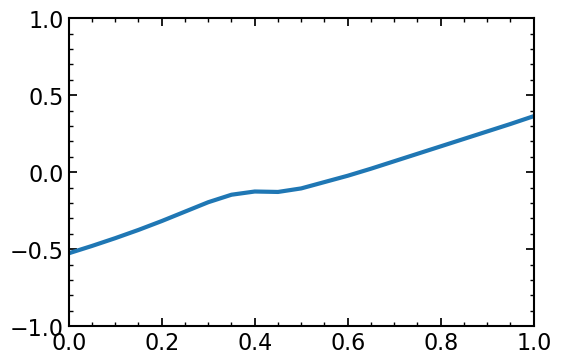

In [43]:
plt.plot(erange, eq)

plt.xlim(0, 1)

plt.ylim(-1, 1)

In [39]:
from scipy.optimize import minimize

In [40]:
minimize(lambda z: get_eq(z, 0)**2, [0.6])

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.1345933880876793e-13
        x: [ 6.263e-01]
      nit: 4
      jac: [ 6.345e-07]
 hess_inv: [[ 5.903e-01]]
     nfev: 10
     njev: 5

In [41]:
get_xs(0)

([0.6124649664513078, 0.6124649664513078],
 [-0.04297625571187137, -0.04297625571187137],
 [0.01246496645130778, 0.01246496645130778])

In [203]:
df.close()

In [166]:
__ = channels_QQ.get_T()

In [198]:
channels_QA['qa1'].chs[0].TM

AttributeError: 'Channel' object has no attribute 'TM'

In [171]:
channels_QQ['qq3'].chs[1].XS

[array([[ 0.01086167+7.38442635e-05j,  0.01086167+7.38442635e-05j,
          0.01086167+7.38442635e-05j, ...,  0.01086167+7.38442635e-05j,
          0.01086167+7.38442635e-05j,  0.01086167+7.38442635e-05j],
        [ 0.01093981+7.49591713e-05j,  0.01093981+7.49591713e-05j,
          0.01093981+7.49591713e-05j, ...,  0.01093981+7.49591713e-05j,
          0.01093981+7.49591713e-05j,  0.01093981+7.49591713e-05j],
        [ 0.01101909+7.60996023e-05j,  0.01101909+7.60996023e-05j,
          0.01101909+7.60996023e-05j, ...,  0.01101909+7.60996023e-05j,
          0.01101909+7.60996023e-05j,  0.01101909+7.60996023e-05j],
        ...,
        [-0.02388578+1.05375777e-03j, -0.02388578+1.05375777e-03j,
         -0.02388578+1.05375777e-03j, ..., -0.02388578+1.05375777e-03j,
         -0.02388578+1.05375777e-03j, -0.02388578+1.05375777e-03j],
        [-0.02417729+6.12164352e-02j, -0.02417729+6.12164352e-02j,
         -0.02417729+6.12164352e-02j, ..., -0.02417729+6.12164352e-02j,
         -0.02417729

In [145]:
get_xs(0.5)

([0.7838913525076949, 0.7838913525076949],
 0.0028663849170295352,
 -0.024985880074876093)

In [144]:
OUT

[([0.6025900959492952, 0.6025900959492952],
  0.0025900959492953088,
  -0.03864067667713826),
 ([0.6108928610053742, 0.6108928610053742],
  0.002616607975552297,
  -0.03787862660005953),
 ([0.6351390728942041, 0.6351390728942041],
  0.002683540860528276,
  -0.03577265477068179),
 ([0.6735828669580936, 0.6735828669580936],
  0.002762473708156587,
  -0.032748188023287945),
 ([0.7239348796933783, 0.7239348796933783],
  0.002824624600580432,
  -0.029288842354522292),
 ([0.7838767782282257, 0.7838767782282257],
  0.002851810637560206,
  -0.025779899050599978),
 ([0.8513662144254537, 0.8513662144254537],
  0.002838077001596541,
  -0.02246453320023873),
 ([0.9247406009668706, 0.9247406009668706],
  0.0027861552375818177,
  -0.01946486593947097),
 ([1.0027031348404065, 1.0027031348404065],
  0.0027031348404064764,
  -0.016822020951578424),
 ([1.084262707059762, 1.084262707059762],
  0.0025973244205653523,
  -0.014530762671229608),
 ([1.168666882698235, 1.168666882698235],
  0.00247650372917497

In [143]:
imss.shape

(51,)

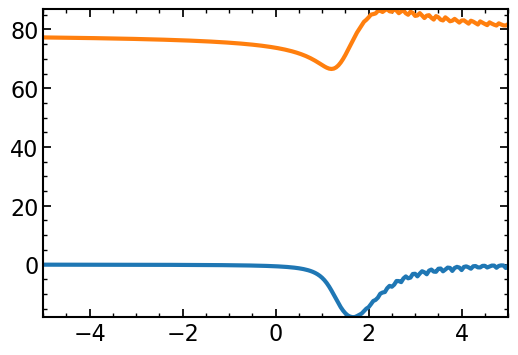

In [27]:
plt.plot(erange, imag(channels_QQ['qq6'].chs[0].TM)[:, 0])
plt.plot(erange, real(channels_QQ['qq6'].chs[0].TM)[:, 0])

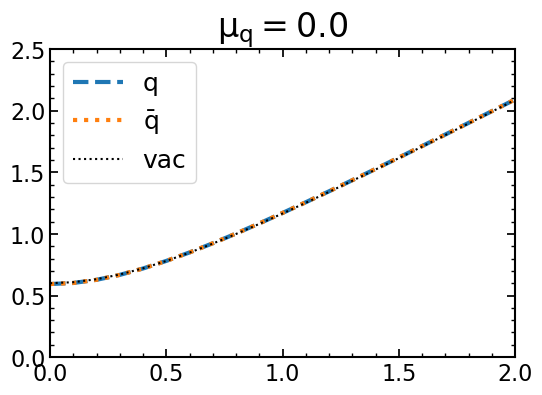

In [28]:
lQ, = plt.plot(qrange, omKs[:, 0], ls='--', label='q')
lA, = plt.plot(qrange, omKs[:, 1], ls=':', label=r'$\bar q$')
plt.plot(qrange, sqrt(mQ**2 + qrange**2), ls=':', lw=1.5, c='black', label='vac')

plt.legend()

plt.xlim(0, 2)
plt.ylim(0, 2.5)
plt.title(fr'$\mu_q = {mu/T}$')

suff = ''
if subtr:
    suff = '_subtr'

# plt.savefig('omk_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')

Text(0.5, 0, 'k [GeV]')

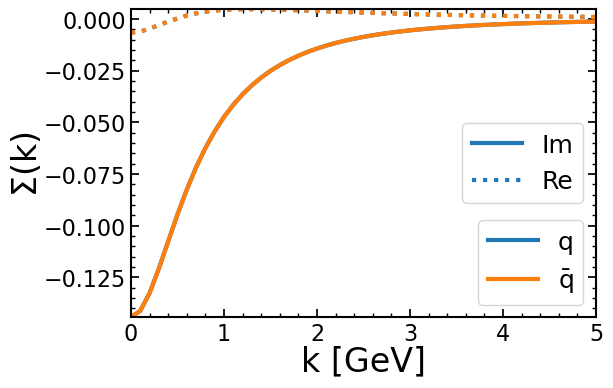

In [29]:
lQ, = plt.plot(qrange, imss[:, 0], ls='-')
lQre, = plt.plot(qrange, ress[:, 0], ls=':', c=lQ.get_c())

lA, = plt.plot(qrange, imss[:, 1], ls='-')
plt.plot(qrange, ress[:, 1], ls=':', c=lA.get_c())

leg = plt.legend([lQ, lQre], ['Im', 'Re'], loc='center right')

leg2 = plt.legend([lQ, lA], ['q', r'$\bar q$'])

plt.gca().add_artist(leg)

# plt.plot(qrange, sqrt(mQ**2 + qrange**2))

# plt.xlim(0, 2)
# plt.ylim(0, 2.5)
plt.ylabel(r'$\Sigma(k)$')
plt.xlabel('k [GeV]')

# plt.savefig('Sk_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')


(0.0, 3.0)

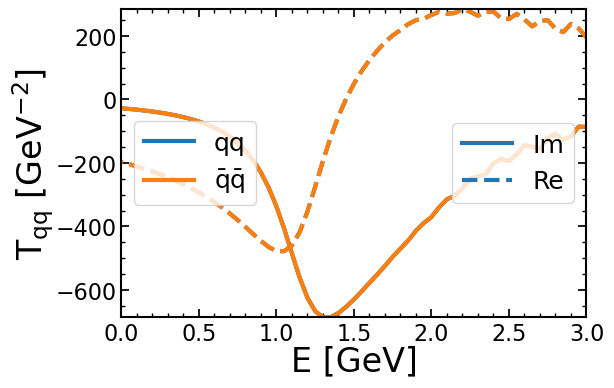

In [30]:
lq, = plt.plot(erange, imag(channels_QQ.get_T())[:, 0], label='qq')
la, = plt.plot(erange, imag(channels_AA.get_T())[:, 0], label='\bar q q')

lqre, = plt.plot(erange, real(channels_QQ.get_T())[:, 0], c=lq.get_c(), ls='--')
plt.plot(erange, real(channels_AA.get_T())[:, 0], c=la.get_c(), ls='--')

plt.ylabel(r'$T_{qq}$ [GeV$^{-2}$]')
plt.xlabel(r'E [GeV]')

leg = plt.legend([lq, lqre], ['Im', 'Re'], loc='center right')

leg2 = plt.legend([lq, la], ['qq', r'$\bar q \bar q$'], loc='center left')
plt.gca().add_artist(leg)

plt.xlim(0, 3)

# plt.savefig('T_qq_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')


(0.0, 3.0)

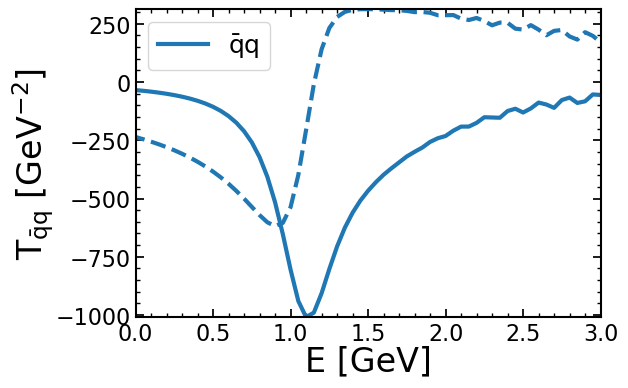

In [32]:
plt.plot(erange, imag(channels_QA.get_T())[:, 0], label=r'$\bar qq$')
# la, = plt.plot(erange, imag(channels_AA.get_T())[:, 0], label='\bar q q')

plt.plot(erange, real(channels_QA.get_T())[:, 0], c=lq.get_c(), ls='--')
# plt.plot(erange, real(channels_AA.get_T())[:, 0], c=la.get_c(), ls='--')

plt.ylabel(r'$T_{\bar qq}$ [GeV$^{-2}$]')
plt.xlabel(r'E [GeV]')

# leg = plt.legend([lq, lqre], ['Im', 'Re'], loc='center right')

# leg2 = plt.legend([lq, la], ['qq', r'$\bar q \bar q$'], loc='center left')
plt.legend()
# plt.gca().add_artist(leg)

plt.xlim(0, 3)
# plt.savefig('T_qa_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')


(0.0, 3.0)

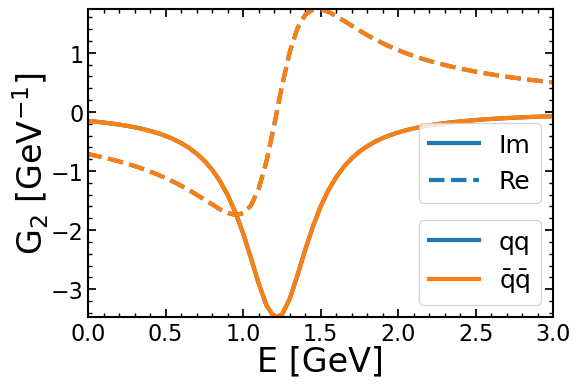

In [33]:
lq, = plt.plot(erange, imag(G2_QQ)[:, 0], label='qq')
la, = plt.plot(erange, imag(G2_AA)[:, 0], label='\bar q q')

lqre, = plt.plot(erange, real(G2_QQ)[:, 0], c=lq.get_c(), ls='--')
plt.plot(erange, real(G2_AA)[:, 0], c=la.get_c(), ls='--')

plt.ylabel(r'$G_{2}$ [GeV$^{-1}$]')
plt.xlabel(r'E [GeV]')

leg = plt.legend([lq, lqre], ['Im', 'Re'], loc='center right')

leg2 = plt.legend([lq, la], ['qq', r'$\bar q \bar q$'], loc='lower right')
plt.gca().add_artist(leg)

plt.xlim(0, 3)

# plt.savefig('G2_qq_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')
